### IMPORTS

In [100]:
import os
import pickle

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from sklearn.ensemble import (
    VotingRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.exceptions import ConvergenceWarning
import warnings


pd.options.display.max_columns = None

###  CONFIGURATIONS

In [23]:
path_raw = './data/'
path_out='./outputs/'
path_out_images='./images/'

###  LOADING DATASETS

In [24]:
data_raw = pd.read_csv(os.path.join(path_raw,'FLXDC_2023 (TCT)_20240612.csv'), low_memory=False, sep=';')
cod_base_guru = pd.read_csv(os.path.join(path_raw,'cods_guru_plantas.csv'), dtype=str)

### HELPERS

In [26]:
def str_to_float(val_str):    
    return float(val_str.replace('.','').replace(",",'.'))

def class_to_num(df, col):
    new_class = {name:num for num,name in enumerate(df[col].unique())}
    return new_class

###  ETL

#### Transforming

In [27]:
df_geral = data_raw.copy()

df_geral['Peso Liquido Delivery'] = df_geral['Peso Liquido Delivery'].map(lambda x: str_to_float(x) if x != '' else 0)
df_geral['FRETE'] = df_geral['FRETE'].map(lambda x: str_to_float(x[1:]) if x != '' else 0)
df_geral['FRETE AJUSTADO'] = df_geral['FRETE AJUSTADO'].map(lambda x: float(x.replace(',','')))
df_geral['KM Ajustado'] = df_geral['KM Ajustado'].map(lambda x: float(x.replace(',','')))

In [28]:
df_geral.describe()

,Nro.Documento,Transportador,Nro.Docto Entrega,Nro. Cliente,Peso Liquido Delivery,V.Bruta S/Imp,ID,FRETE,M3,FRETE AJUSTADO,KM,Bolsas,KM Ajustado,M3 Carga,Viagens,Fator RM,Latitude Origem,Longitude Origem,Latitude Destino,Longitude Destino,Peso Bruto da Prod,Material,Quantidade,Diaria
count,1.003547e+06,1.003483e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06,966161.000000,966161.000000,1.003547e+06,1.003547e+06,1.003547e+06,1.003547e+06
mean,8.931008e+06,1.999013e+09,2.300806e+09,4.584479e+07,6.284565e+02,8.818150e+04,3.993864e+06,5.023697e+03,7.657798e+00,4.953592e+02,5.364727e+02,5.000029e+03,5.872565e+01,6.890865e+01,1.198861e-01,2.327853e+05,-2.219433e+01,-4.610842e+01,-21.123146,-46.577026,7.426262e+02,3.000490e+08,2.076928e+02,2.228351e+01
std,3.695474e+05,3.151815e+07,1.641178e+09,5.053985e+07,1.746030e+03,6.456706e+04,2.346085e+05,5.498437e+03,1.253780e+01,1.174048e+03,7.075738e+02,1.140814e+04,1.555031e+02,9.632619e+01,1.862111e-01,1.875045e+06,4.131849e+00,3.273757e+00,6.182090,4.496195,2.466701e+03,1.238547e+04,4.137235e+02,1.937227e+02
min,8.201344e+06,1.000027e+09,8.073653e+08,7.816000e+03,0.000000e+00,-7.227290e+03,1.234000e+03,0.000000e+00,0.000000e+00,0.000000e+00,8.900000e+00,0.000000e+00,1.100000e-01,1.522728e-02,0.000000e+00,0.000000e+00,-2.987264e+01,-5.124727e+01,-32.083988,-67.840585,0.000000e+00,3.000043e+08,0.000000e+00,-1.380000e+02
25%,8.616698e+06,2.000005e+09,8.116396e+08,7.862000e+03,2.979000e+00,2.690100e+04,3.945830e+06,1.306820e+03,1.004475e+00,5.512825e+01,7.147000e+01,6.400000e+02,5.910000e+00,4.955356e+01,2.095152e-02,5.985966e+03,-2.356966e+01,-4.709020e+01,-23.560381,-48.319028,7.693488e+01,3.000471e+08,4.000000e+01,0.000000e+00
50%,8.923238e+06,2.000008e+09,8.124177e+08,7.962000e+03,4.173000e+00,8.010628e+04,3.986844e+06,3.560500e+03,3.192000e+00,1.703169e+02,3.951380e+02,1.764000e+03,2.129000e+01,7.893051e+01,5.090114e-02,2.888205e+04,-2.325176e+01,-4.709020e+01,-23.306990,-46.745742,1.794065e+02,3.000530e+08,8.700000e+01,0.000000e+00
75%,9.248574e+06,2.000009e+09,4.108746e+09,1.003229e+08,4.480000e+02,1.459905e+05,4.025630e+06,6.265000e+03,8.640000e+00,4.514036e+02,6.562220e+02,4.455000e+03,5.433000e+01,8.858993e+01,1.350490e-01,1.049054e+05,-2.325176e+01,-4.643761e+01,-20.723227,-44.047283,4.840462e+02,3.000577e+08,2.000000e+02,0.000000e+00
max,9.581241e+06,2.000012e+09,4.118840e+09,1.042951e+08,5.773200e+04,7.390278e+05,9.573512e+06,4.397380e+04,1.409509e+02,4.359008e+04,5.363200e+03,3.519180e+05,5.295000e+03,8.644708e+03,1.000000e+00,1.188897e+08,-8.342841e+00,-3.502289e+01,2.807368,-34.843039,7.924672e+04,3.000612e+08,1.303400e+04,8.494408e+04


####  Cleaning

In [39]:
df_geral = df_geral[~df_geral['UF Destino'].isin(['0','1'])]
df_geral = df_geral[df_geral['FRETE']>= 0.1]
df_geral = df_geral[df_geral['Planta'] != '7958']
df_geral.loc[
    (df_geral['Planta'] == '7961') 
    & (df_geral['CHAVE ORIGEM'] == 'CONTAGEMMG'), 
    'CHAVE ORIGEM'
] = 'SETE LAGOASMG'

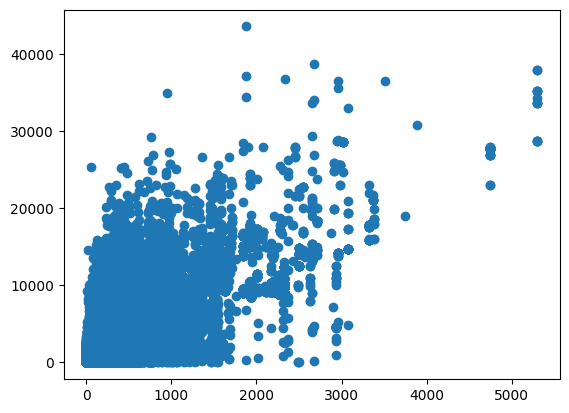

In [40]:
plt.scatter(df_geral['KM Ajustado'],df_geral['FRETE AJUSTADO'])

#### Agreggation

In [41]:
features= [
    'Planta', 'CHAVE ORIGEM','Movimentação',
    'UF Destino', 'TIPO',
]

num_cols = [
    'Quantidade','FRETE AJUSTADO',
]

df_agg = df_geral[
    ['CHAVE DESTINO']+ features + num_cols
    ].groupby(
        ['CHAVE DESTINO']+features).sum().reset_index()

_df_agg_mean = df_geral[
    ['Nro.Documento','Data','CHAVE DESTINO']+ features + num_cols
    ].groupby(
        ['Nro.Documento','Data','CHAVE DESTINO']+features).sum().reset_index()
_df_agg_mean['RealCaixa'] = _df_agg_mean['FRETE AJUSTADO'] / _df_agg_mean['Quantidade']

_df_agg_mean = _df_agg_mean[
    ['CHAVE DESTINO']+ features + num_cols + ['RealCaixa']
    ].groupby(
        ['CHAVE DESTINO']+features).mean().reset_index()

df_agg = pd.merge(
    df_agg,
    _df_agg_mean[['CHAVE DESTINO']+ features + ['RealCaixa']].rename(columns={'RealCaixa':'RealCaixaMean'}),
    on=['CHAVE DESTINO']+ features,
    how='left'
)

_df_agg_km = df_geral[['CHAVE ORIGEM','CHAVE DESTINO','KM']].drop_duplicates()

df_agg = pd.merge(
    df_agg,
    _df_agg_km.rename(columns={'KM':'KM Ajustado'}),
    on=['CHAVE ORIGEM','CHAVE DESTINO'],
    how='left'
)


#### Filtering

In [42]:
col_target = 'RealCaixaMean'

### Initial hard filter
df_agg = df_agg[df_agg[col_target] < df_agg[col_target].mean() * 10]

### Categorical to Numerical
for feature in features:
    new_class = class_to_num(df_agg, feature)
    df_agg[feature+'_Class'] = df_agg[feature].map(lambda x: new_class[x])

In [43]:
# ### Filter to get the data in the middle 50% 
df_qt = df_agg[
    features + ['CHAVE DESTINO'] + [col_target]
    ].groupby(
       features + ['CHAVE DESTINO']
    ).quantile(q=.25).reset_index().rename(columns={col_target:'%25'})
df_qt['%75'] = df_agg[
    features + ['CHAVE DESTINO'] + [col_target]
    ].groupby(
       features + ['CHAVE DESTINO']
    ).quantile(q=.75).reset_index()[col_target]

df_qt['Len'] = df_agg[
    features + ['CHAVE DESTINO'] + [col_target]
    ].groupby(
       features + ['CHAVE DESTINO']
    ).count().reset_index()[col_target]


df_agg = pd.merge(
    df_agg,
    df_qt,
    on=features + ['CHAVE DESTINO'],
    how='left',
)

df_filt_len2 = df_agg[df_agg['Len'] <3].copy()
df_filt = df_agg[(df_agg[col_target]>= df_agg['%25']) & (df_agg[col_target]<=df_agg['%75'])].copy()
df_filt = pd.concat(
    [
        df_filt,
        df_filt_len2
    ],
    ignore_index=True
)

df_filt['VENDAS'] = df_filt['Movimentação'] == 'VENDAS'
df_filt['TRANSFERENCIA'] = df_filt['Movimentação'] == 'TRANSFERENCIA'

### Model


Estatísticas com transformação log:
count    3294.000000
mean       10.693631
std         2.193371
min         2.335052
25%         9.299846
50%        10.589103
75%        12.261069
max        16.940632
Name: FRETE AJUSTADO, dtype: float64


Text(0, 0.5, 'Frequência')

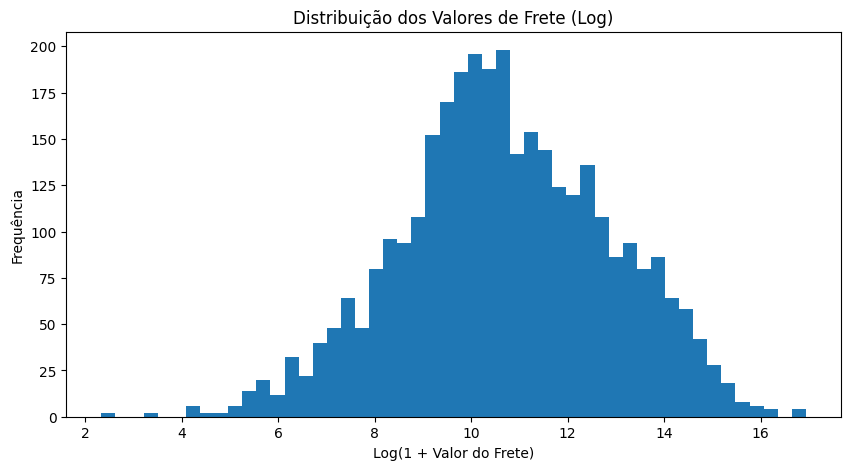

In [79]:
# Distribuição após transformação log
print("\nEstatísticas com transformação log:")
print(np.log1p(df_filt['FRETE AJUSTADO']).describe())

plt.figure(figsize=(10,5))
plt.hist(np.log1p(df_filt['FRETE AJUSTADO']), bins=50)
plt.title('Distribuição dos Valores de Frete (Log)')
plt.xlabel('Log(1 + Valor do Frete)')
plt.ylabel('Frequência')

Estatísticas do RealCaixaMean:
Estatísticas após transformação log:
count    3294.000000
mean        1.694025
std         0.749976
min         0.050366
25%         1.160540
50%         1.672152
75%         2.266211
max         4.078886
Name: RealCaixaMean, dtype: float64


Text(0, 0.5, 'Frequência')

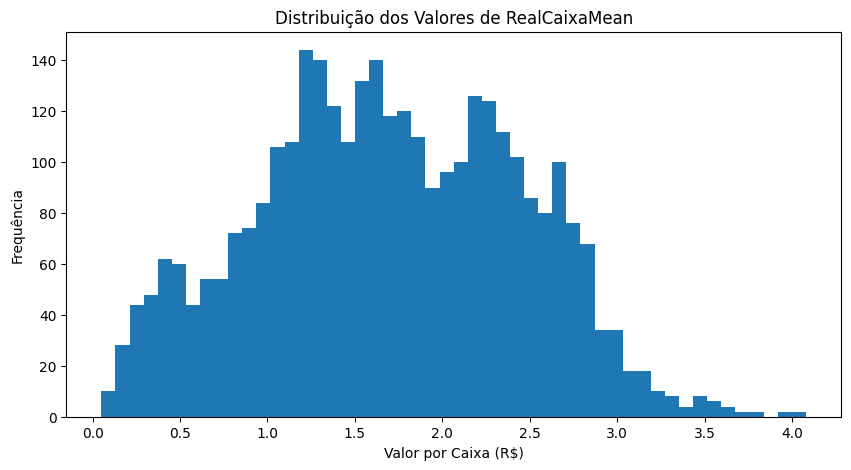

In [81]:
print("Estatísticas do RealCaixaMean:")
# Ajustar o target para log
y_target = np.log1p(df_filt['RealCaixaMean'])


print("Estatísticas após transformação log:")
print(y_target.describe())

plt.figure(figsize=(10,5))
plt.hist(y_target, bins=50)
plt.title('Distribuição dos Valores de RealCaixaMean')
plt.xlabel('Valor por Caixa (R$)')
plt.ylabel('Frequência')



Iniciando treinamento com ajuste fino...
Preparando features...
Criando estratificação...
Dividindo dados...
Treinando modelo - Etapa 1 (Grid Inicial)...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Melhores parâmetros da primeira etapa:
RF max_depth: 10
RF min_samples_split: 2
GB learning_rate: 0.05
GB subsample: 0.9

Treinando modelo - Etapa 2 (Grid Fino)...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Melhores parâmetros finais:
{'ensemble__gb__learning_rate': 0.05, 'ensemble__gb__subsample': 0.9, 'ensemble__rf__max_depth': 11, 'ensemble__rf__min_samples_split': 2}

Métricas de Avaliação:
R² Treino: 0.925
R² Teste: 0.858
MAPE Treino: 10.1%
MAPE Teste: 12.1%
RMSE Treino: 0.20
RMSE Teste: 0.29

Métricas de Avaliação:
R² Treino: 0.925
R² Teste: 0.858
MAPE Treino: 10.1%
MAPE Teste: 12.1%
RMSE Treino: 0.20
RMSE Teste: 0.29

Importância das Features (top 10):
             feature  importance
25  km_vendas_planta    0.479982
15           tipo_km    0.142

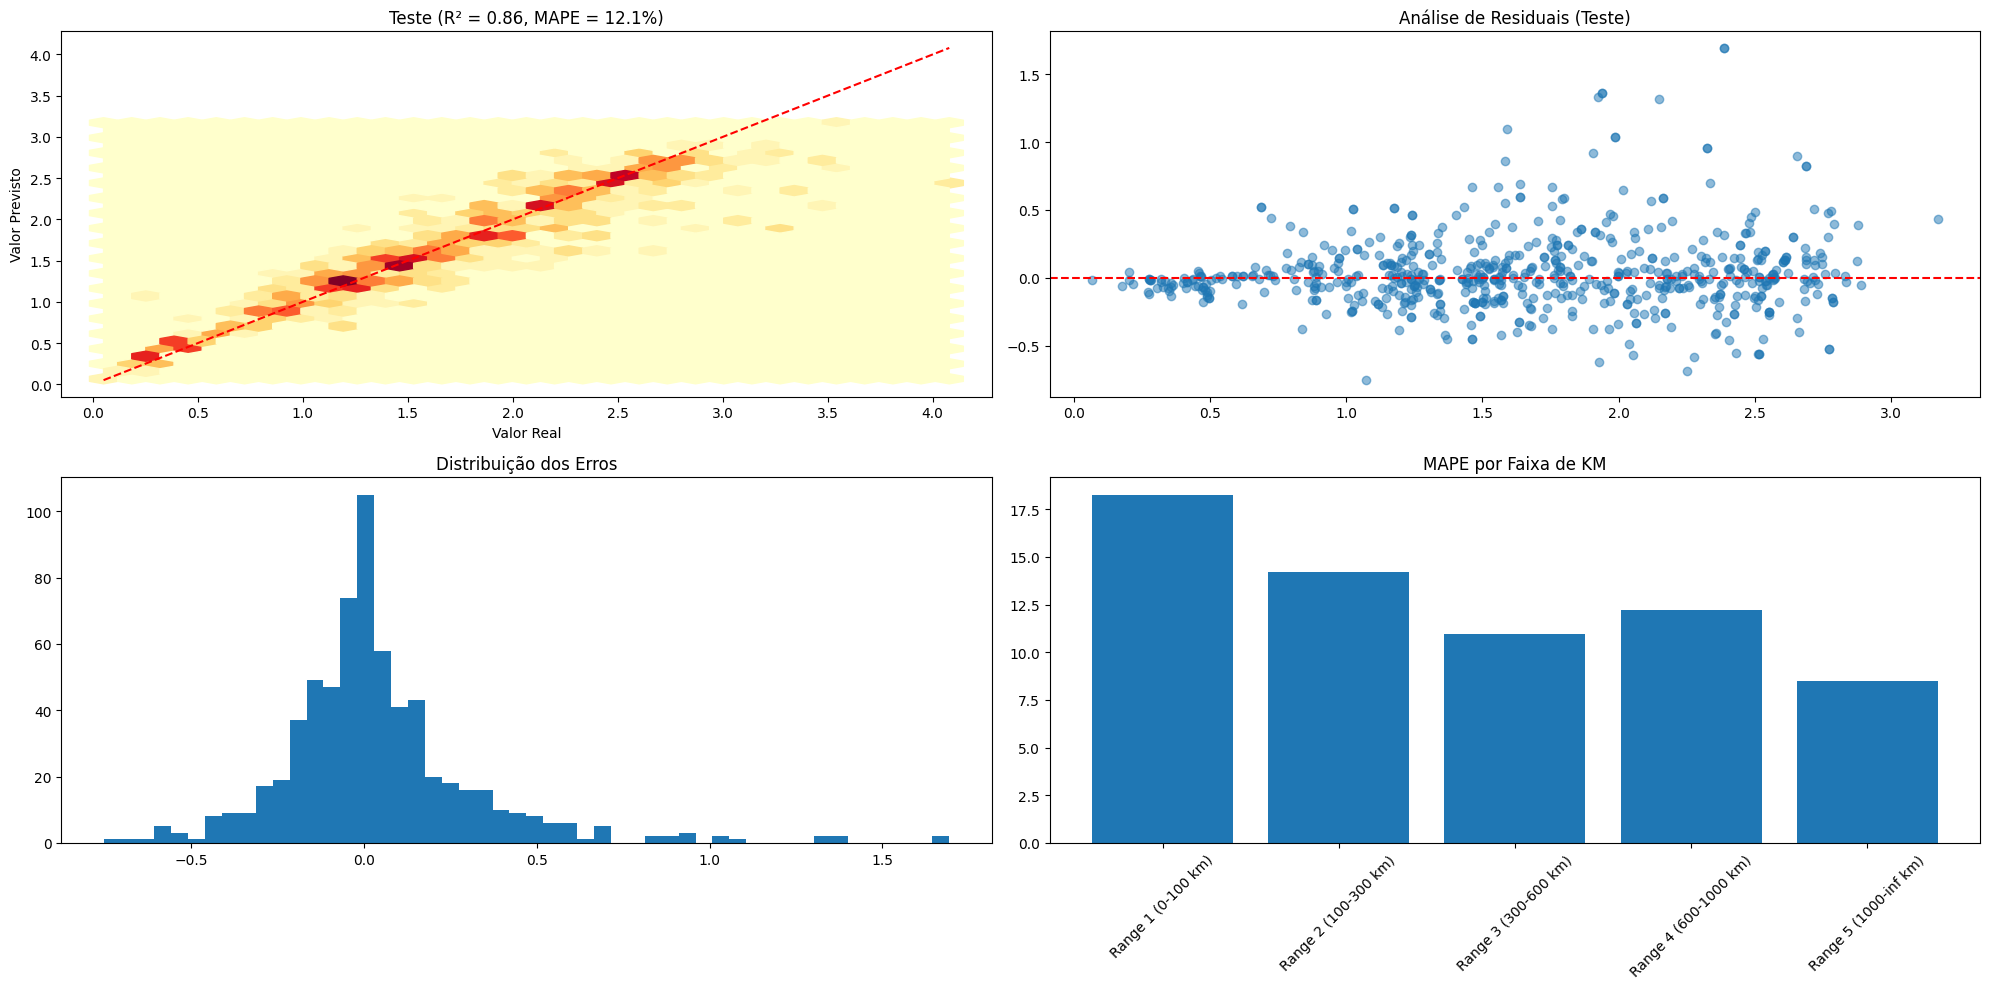

<Figure size 1200x600 with 0 Axes>

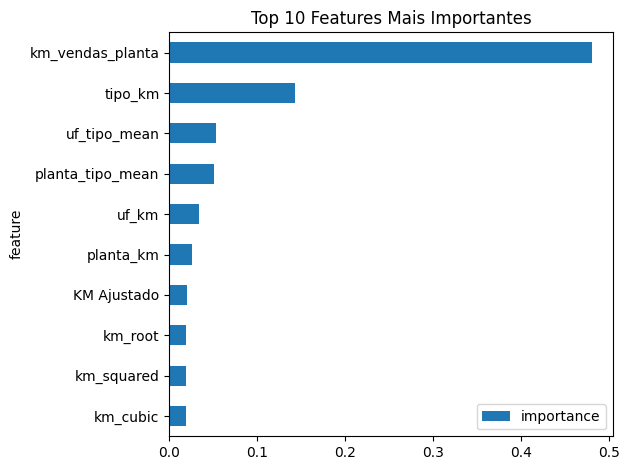

In [82]:
# Preparação dos dados iniciais
# Definir features categóricas
features = [
    'Planta', 'CHAVE ORIGEM', 'Movimentação',
    'UF Destino', 'TIPO',
]

# Criar eng_classes (colunas categóricas transformadas)
eng_classes = [f"{feature}_Class" for feature in features if feature != 'CHAVE ORIGEM']

#  Preparar X e y inicial
X_Model = df_filt[['KM Ajustado','VENDAS','TRANSFERENCIA'] + eng_classes]
y_target = np.log1p(df_filt['RealCaixaMean']).to_numpy()

# Funções auxiliares
def remove_outliers(X, y, z_threshold=2.5):
    """Remove outliers usando z-score"""
    scaler = RobustScaler()
    z_scores = np.abs(scaler.fit_transform(y.reshape(-1, 1)))
    mask = z_scores < z_threshold
    return X[mask.flatten()], y[mask.flatten()]

def post_process_predictions(y_pred, y_train):
    """Pós-processa as previsões"""
    y_pred = np.maximum(y_pred, 0)
    upper_limit = y_train.mean() + 3 * y_train.std()
    y_pred = np.minimum(y_pred, upper_limit)
    return y_pred

def compute_sample_weights(y):
    """Calcula pesos das amostras"""
    bins = pd.qcut(y, q=10, labels=False)
    weights = 1 / pd.Series(bins).value_counts()[bins].values
    return weights / weights.sum() * len(weights)

# Feature Engineering
def create_features(X, df_original):
    """Cria features engineered com foco nas interações mais importantes"""
    X_new = X.copy()
    
    # Features básicas de KM
    X_new['km_log'] = np.log1p(X['KM Ajustado'])
    X_new['km_root'] = np.sqrt(X['KM Ajustado'])
    X_new['km_squared'] = X['KM Ajustado'] ** 2
    X_new['km_cubic'] = X['KM Ajustado'] ** 3
    
    # Interações com KM
    X_new['km_vendas'] = X['KM Ajustado'] * X['VENDAS']
    X_new['km_transfer'] = X['KM Ajustado'] * X['TRANSFERENCIA']
    
    # Interações com features importantes
    X_new['planta_km'] = X['KM Ajustado'] * X['Planta_Class']
    X_new['uf_km'] = X['KM Ajustado'] * X['UF Destino_Class']
    X_new['tipo_km'] = X['KM Ajustado'] * X['TIPO_Class']
    
    # Features de agrupamento básicas
    for feature in ['Planta', 'UF Destino', 'TIPO']:
        X_new[f'mean_by_{feature}'] = df_original.groupby(feature)[col_target].transform('mean')
        X_new[f'std_by_{feature}'] = df_original.groupby(feature)[col_target].transform('std')
        X_new[f'median_by_{feature}'] = df_original.groupby(feature)[col_target].transform('median')
    
    # Novas interações baseadas nas features mais importantes
    X_new['km_vendas_planta'] = X_new['km_vendas'] * X_new['mean_by_Planta']
    X_new['km_vendas_tipo'] = X_new['km_vendas'] * X_new['mean_by_TIPO']
    
    # Features de densidade/frequência
    X_new['densidade_regiao'] = df_original.groupby('UF Destino')['CHAVE DESTINO'].transform('count')
    X_new['freq_planta'] = df_original.groupby('Planta')['CHAVE DESTINO'].transform('count')
    
    # Interações complexas
    X_new['planta_tipo_mean'] = df_original.groupby(['Planta', 'TIPO'])[col_target].transform('mean')
    X_new['uf_tipo_mean'] = df_original.groupby(['UF Destino', 'TIPO'])[col_target].transform('mean')
    
    return X_new

# Pipeline 
def create_ensemble_pipeline():
    """Cria pipeline com ensemble de modelos otimizado"""
    rf = RandomForestRegressor(
        n_estimators=1000,
        random_state=42,
        n_jobs=-1,
        warm_start=True,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True  
    )
    
    gb = GradientBoostingRegressor(
        n_estimators=1000,
        random_state=42,
        warm_start=True,
        validation_fraction=0.15,
        n_iter_no_change=20,     
        tol=1e-5,
        subsample=0.8
    )
    
    et = ExtraTreesRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        warm_start=True,
        max_features='sqrt',
        bootstrap=True
    )
    
    hub = HuberRegressor(
        max_iter=5000,        
        epsilon=1.35,
        tol=1e-4,            
        warm_start=True,
        fit_intercept=True,
        alpha=0.001         
    )
    
  
    ensemble = VotingRegressor([
        ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('hub', hub)
    ], weights=[0.50, 0.35, 0.10, 0.05])
    
    return Pipeline([
        ('scaler', RobustScaler()),
        ('ensemble', ensemble)
    ])

# Grid de hiperparâmetros
param_grid_inicial = {
    'ensemble__rf__max_depth': [6, 8, 10],
    'ensemble__rf__min_samples_split': [2, 5, 10],
    'ensemble__gb__learning_rate': [0.01, 0.05, 0.1],
    'ensemble__gb__subsample': [0.7, 0.8, 0.9]
}

# Treinamento
def train_ensemble_model(X, y, df_original):
    """Treina o modelo ensemble com ajuste fino de hiperparâmetros"""
    print("Preparando features...")
    X_processed = create_features(X, df_original)
    X_clean, y_clean = remove_outliers(X_processed, y, z_threshold=2.5)
    
    y_log = np.log1p(y_clean)
    print("Criando estratificação...")
    y_bins = pd.qcut(y_log, q=10, labels=False)
    
    print("Dividindo dados...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_log,
        test_size=0.2,
        random_state=42,
        stratify=y_bins
    )
    
    sample_weights = compute_sample_weights(y_train)
    
    # Primeira etapa - Grid inicial
    print("Treinando modelo - Etapa 1 (Grid Inicial)...")
    pipeline = create_ensemble_pipeline()
    grid_search_1 = GridSearchCV(
        pipeline,
        param_grid_inicial,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_1.fit(X_train, y_train, ensemble__sample_weight=sample_weights)
    
    # Extrair melhores parâmetros
    best_params = grid_search_1.best_params_
    best_depth = best_params['ensemble__rf__max_depth']
    best_split = best_params['ensemble__rf__min_samples_split']
    best_lr = best_params['ensemble__gb__learning_rate']
    best_subsample = best_params['ensemble__gb__subsample']
    
    print(f"\nMelhores parâmetros da primeira etapa:")
    print(f"RF max_depth: {best_depth}")
    print(f"RF min_samples_split: {best_split}")
    print(f"GB learning_rate: {best_lr}")
    print(f"GB subsample: {best_subsample}")
    
    # Segunda etapa - Grid fino
    print("\nTreinando modelo - Etapa 2 (Grid Fino)...")
    param_grid_fino = {
        'ensemble__rf__max_depth': [max(4, best_depth-1), best_depth, best_depth+1],
        'ensemble__rf__min_samples_split': [max(2, best_split-1), best_split, min(20, best_split+1)],
        'ensemble__gb__learning_rate': [best_lr*0.5, best_lr, best_lr*1.5],
        'ensemble__gb__subsample': [max(0.5, best_subsample-0.1), best_subsample, min(1.0, best_subsample+0.1)]
    }
    
    grid_search_2 = GridSearchCV(
        pipeline,
        param_grid_fino,
        cv=3,
        scoring=['r2', 'neg_mean_absolute_percentage_error'],
        refit='r2',
        n_jobs=-1,
        verbose=1
    )
    
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    grid_search_2.fit(X_train, y_train, ensemble__sample_weight=sample_weights)
    
    print("\nMelhores parâmetros finais:")
    print(grid_search_2.best_params_)
    
    return grid_search_2, X_train, X_test, y_train, y_test

# Avaliação
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Avalia o modelo com métricas por faixa de KM"""
    def evaluate_by_km_range(X, y_true, y_pred, km_ranges):
        metrics_by_range = {}
        for i, (km_min, km_max) in enumerate(km_ranges):
            mask = (X['KM Ajustado'] >= km_min) & (X['KM Ajustado'] < km_max)
            if mask.any():
                metrics_by_range[f'Range {i+1} ({km_min}-{km_max} km)'] = {
                    'r2': r2_score(y_true[mask], y_pred[mask]),
                    'mape': mean_absolute_percentage_error(y_true[mask], y_pred[mask]),
                    'rmse': np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
                }
        return metrics_by_range
    
    # Predições e transformações
    y_pred_train = np.expm1(model.predict(X_train))
    y_pred_test = np.expm1(model.predict(X_test))
    
    y_train_original = np.expm1(y_train)
    y_test_original = np.expm1(y_test)
    
    # Pós-processamento por faixa
    km_ranges = [(0, 100), (100, 300), (300, 600), (600, 1000), (1000, float('inf'))]
    
    # Métricas gerais
    metrics = {
        'train_r2': r2_score(y_train_original, y_pred_train),
        'test_r2': r2_score(y_test_original, y_pred_test),
        'train_mape': mean_absolute_percentage_error(y_train_original, y_pred_train),
        'test_mape': mean_absolute_percentage_error(y_test_original, y_pred_test),
        'train_rmse': np.sqrt(mean_squared_error(y_train_original, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test_original, y_pred_test)),
        'train_by_range': evaluate_by_km_range(X_train, y_train_original, y_pred_train, km_ranges),
        'test_by_range': evaluate_by_km_range(X_test, y_test_original, y_pred_test, km_ranges)
    }
    
    fig = plt.figure(figsize=(20, 10))
    
    # Plot 1: Dispersão
    ax1 = plt.subplot(221)
    ax1.hexbin(y_test_original, y_pred_test, gridsize=30, cmap='YlOrRd')
    ax1.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 'r--')
    ax1.set_title(f'Teste (R² = {metrics["test_r2"]:.2f}, MAPE = {metrics["test_mape"]*100:.1f}%)')
    ax1.set_xlabel('Valor Real')
    ax1.set_ylabel('Valor Previsto')
    
    # Residuais
    ax2 = plt.subplot(222)
    residuals = y_test_original - y_pred_test
    ax2.scatter(y_pred_test, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_title('Análise de Residuais (Teste)')
    
    # Distribuição dos Erros
    ax3 = plt.subplot(223)
    ax3.hist(residuals, bins=50)
    ax3.set_title('Distribuição dos Erros')
    
    # Erro por Faixa de KM
    ax4 = plt.subplot(224)
    mape_by_range = []
    range_labels = []
    for range_name, metrics_range in metrics['test_by_range'].items():
        mape_by_range.append(metrics_range['mape'] * 100)
        range_labels.append(range_name)
    ax4.bar(range_labels, mape_by_range)
    ax4.set_title('MAPE por Faixa de KM')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    return metrics, fig

#  Execução
# print("Iniciando treinamento...")
# model, X_train, X_test, y_train, y_test = train_ensemble_model(X_Model, y_target, df_filt)
# metrics, fig = evaluate_model(model, X_train, X_test, y_train, y_test)
print("Iniciando treinamento com ajuste fino...")
model, X_train, X_test, y_train, y_test = train_ensemble_model(X_Model, y_target, df_filt)
metrics, fig = evaluate_model(model, X_train, X_test, y_train, y_test)

#  Salvamento e resultados
os.makedirs(path_out_images, exist_ok=True)
os.makedirs(path_out, exist_ok=True)
fig.savefig(os.path.join(path_out_images, 'Ensemble_Model_Evaluation_v2.png'), dpi=200)
pickle.dump(model, open(os.path.join(path_out, "pepsico_frete_ensemble_v2.sav"), 'wb'))

print("\nMétricas de Avaliação:")
print(f"R² Treino: {metrics['train_r2']:.3f}")
print(f"R² Teste: {metrics['test_r2']:.3f}")
print(f"MAPE Treino: {metrics['train_mape']*100:.1f}%")
print(f"MAPE Teste: {metrics['test_mape']*100:.1f}%")
print(f"RMSE Treino: {metrics['train_rmse']:.2f}")
print(f"RMSE Teste: {metrics['test_rmse']:.2f}")

#  Salvar resultados
os.makedirs(path_out_images, exist_ok=True)
os.makedirs(path_out, exist_ok=True)
fig.savefig(os.path.join(path_out_images, 'Ensemble_Model_Evaluation.png'), dpi=200)
pickle.dump(model, open(os.path.join(path_out, "pepsico_frete_ensemble.sav"), 'wb'))


print("\nMétricas de Avaliação:")
print(f"R² Treino: {metrics['train_r2']:.3f}")
print(f"R² Teste: {metrics['test_r2']:.3f}")
print(f"MAPE Treino: {metrics['train_mape']*100:.1f}%")
print(f"MAPE Teste: {metrics['test_mape']*100:.1f}%")
print(f"RMSE Treino: {metrics['train_rmse']:.2f}")
print(f"RMSE Teste: {metrics['test_rmse']:.2f}")

# Análise de importância das features
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

print("\nImportância das Features (top 10):")
print(feature_importance.sort_values('importance', ascending=False).head(10))

#  Plot da importância das features
plt.figure(figsize=(12, 6))
feature_importance.sort_values('importance').tail(10).plot(
    x='feature', 
    y='importance', 
    kind='barh'
)
plt.title('Top 10 Features Mais Importantes')
plt.tight_layout()
plt.savefig(os.path.join(path_out_images, 'Feature_Importance.png'), dpi=200)

### Inferência 

In [104]:
def plot_km_vs_frete(X_test, y_test_original, y_pred_test):
    plt.figure(figsize=(15, 8))
    
    # Plot dos dados reais e previstos com menor opacidade
    plt.scatter(X_test['KM Ajustado'], y_test_original,
               alpha=0.3, label='Frete Real', 
               color='blue', s=30)
    plt.scatter(X_test['KM Ajustado'], y_pred_test,
               alpha=0.3, label='Frete Previsto', 
               color='red', s=30)
    
    plt.xlabel('KM Ajustado')
    plt.ylabel('Valor do Frete por Caixa (R$/cx)')
    plt.title('Comparação: Frete Real vs Previsto por KM')
    

    # Ordenar dados 
    x_sorted = np.sort(X_test['KM Ajustado'])
    
    # Linha de tendência para dados reais
    slope_real, intercept_real, r_value_real, p_value_real, std_err_real = stats.linregress(X_test['KM Ajustado'], y_test_original)
    line_real = slope_real * x_sorted + intercept_real
    
    # Intervalo de confiança para linha de tendência real
    n = len(X_test)
    x_mean = np.mean(X_test['KM Ajustado'])
    x_std = np.std(X_test['KM Ajustado'])
    
    # Erro padrão da estimativa
    y_pred_line = slope_real * X_test['KM Ajustado'] + intercept_real
    std_error = np.sqrt(np.sum((y_test_original - y_pred_line) ** 2) / (n-2))
    
    # Intervalo de confiança (95%)
    ci = 1.96 * std_error * np.sqrt(1/n + (x_sorted - x_mean)**2 / (n * x_std**2))
    
    # Plotar intervalo de confiança com gradiente
    plt.fill_between(x_sorted, 
                    line_real - ci, 
                    line_real + ci, 
                    color='blue', 
                    alpha=0.1,
                    label='IC 95% Tendência')
    
    # Plotar linhas de tendência por cima
    plt.plot(x_sorted, line_real, 'b-+', 
            linewidth=2, label='Tendência Real')
    plt.plot(x_sorted, 
            slope_real * x_sorted + intercept_real, 
            "r-", 
            linewidth=2,
            label='Tendência Prevista')
    
    # Ajustar limites e grade
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.legend(loc='upper left')
    
    # Métricas por faixa de KM
    km_ranges = [(0, 100), (100, 300), (300, 600), (600, 1000), (1000, float('inf'))]
    for km_min, km_max in km_ranges:
        mask = (X_test['KM Ajustado'] >= km_min) & (X_test['KM Ajustado'] < km_max)
        if mask.any():
            # Cálculos básicos
            y_true = y_test_original[mask]
            y_pred = y_pred_test[mask]
            mape = mean_absolute_percentage_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            
            # Cálculo do intervalo de confiança (95%)
            n = len(y_pred)
            errors = y_true - y_pred
            std_error = np.std(errors)
            margin_of_error = 1.96 * std_error / np.sqrt(n)  # IC 95%
            
            mean_real = np.mean(y_true)
            mean_pred = np.mean(y_pred)
            
            print(f"\nFaixa {km_min}-{km_max}km:")
            print(f"MAPE: {mape*100:.1f}%")
            print(f"R²: {r2:.3f}")
            print(f"Média Frete Real: R$ {mean_real:.2f}/cx")
            print(f"Média Frete Previsto: R$ {mean_pred:.2f}/cx (IC 95%: R$ {mean_pred-margin_of_error:.2f} - R$ {mean_pred+margin_of_error:.2f})")
    
    plt.tight_layout()
    return plt.gcf()

def predict_frete(model, km_ajustado, X_test, y_test_original, y_pred_test,
                 vendas=0, transferencia=0, planta_class=0, 
                 movimentacao_class=0, uf_destino_class=0, tipo_class=0):
    """
    Faz previsão do valor do frete por caixa com intervalo de confiança
    """
    # Fazer previsão pontual
    X_new = pd.DataFrame({
        'KM Ajustado': [km_ajustado],
        'VENDAS': [vendas],
        'TRANSFERENCIA': [transferencia],
        'Planta_Class': [planta_class],
        'Movimentação_Class': [movimentacao_class],
        'UF Destino_Class': [uf_destino_class],
        'TIPO_Class': [tipo_class]
    })
    
    X_processed = create_features(X_new, df_filt)
    y_pred_log = model.predict(X_processed)
    y_pred = np.expm1(y_pred_log)[0]
    
    # Calcular intervalo de confiança baseado na faixa de KM
    if km_ajustado <= 100:
        km_range = (0, 100)
    elif km_ajustado <= 300:
        km_range = (100, 300)
    elif km_ajustado <= 600:
        km_range = (300, 600)
    elif km_ajustado <= 1000:
        km_range = (600, 1000)
    else:
        km_range = (1000, float('inf'))
    
    # Calcular erro padrão para a faixa de KM
    mask = (X_test['KM Ajustado'] >= km_range[0]) & (X_test['KM Ajustado'] < km_range[1])
    errors = y_test_original[mask] - y_pred_test[mask]
    std_error = np.std(errors)
    confidence_interval = 1.96 * std_error  # 95% intervalo de confiança
    
    return {
        'previsao': y_pred,
        'intervalo_inferior': y_pred - confidence_interval,
        'intervalo_superior': y_pred + confidence_interval,
        'erro_padrao': std_error,
        'faixa_km': km_range
    }


Faixa 0-100km:
MAPE: 18.3%
R²: 0.737
Média Frete Real: R$ 1.24/cx
Média Frete Previsto: R$ 1.23/cx (IC 95%: R$ 1.16 - R$ 1.29)

Faixa 100-300km:
MAPE: 14.2%
R²: 0.781
Média Frete Real: R$ 1.50/cx
Média Frete Previsto: R$ 1.38/cx (IC 95%: R$ 1.32 - R$ 1.44)

Faixa 300-600km:
MAPE: 11.0%
R²: 0.885
Média Frete Real: R$ 1.62/cx
Média Frete Previsto: R$ 1.61/cx (IC 95%: R$ 1.57 - R$ 1.65)

Faixa 600-1000km:
MAPE: 12.2%
R²: 0.857
Média Frete Real: R$ 1.84/cx
Média Frete Previsto: R$ 1.79/cx (IC 95%: R$ 1.74 - R$ 1.85)

Faixa 1000-infkm:
MAPE: 8.5%
R²: 0.797
Média Frete Real: R$ 2.12/cx
Média Frete Previsto: R$ 2.08/cx (IC 95%: R$ 2.04 - R$ 2.12)


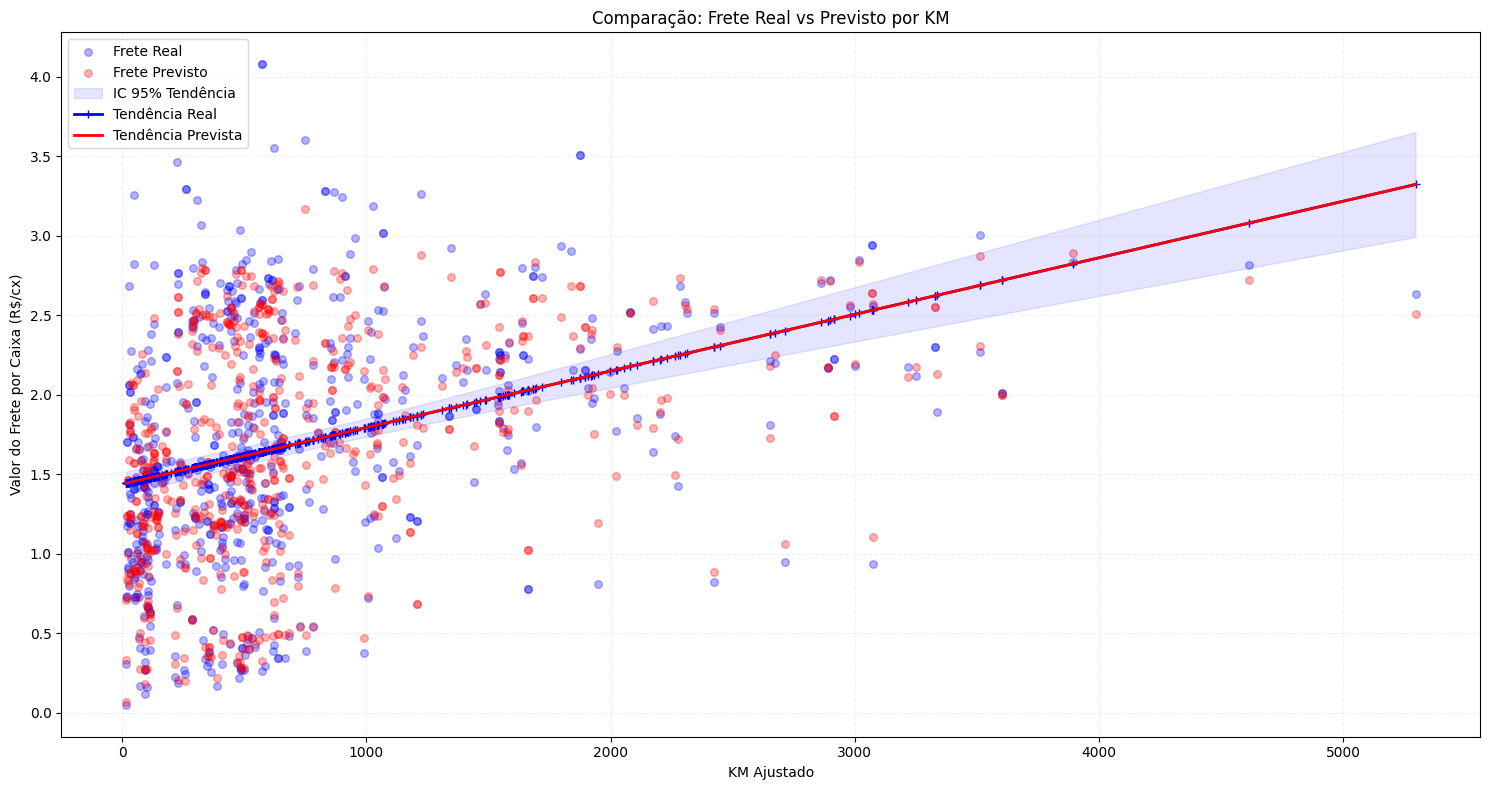

In [105]:
# Obter as previsões do modelo e transformar para escala original
y_pred_test = np.expm1(model.predict(X_test))
y_test_original = np.expm1(y_test)

# Plotar comparação
fig_comparison = plot_km_vs_frete(X_test, y_test_original, y_pred_test)

# Salvar o gráfico
plt.savefig(os.path.join(path_out_images, 'KM_vs_Frete_Comparison.png'), 
            dpi=200, 
            bbox_inches='tight')

def demonstrar_previsao():
    km_examples = [50, 200, 400, 800, 1200]
    
    for km in km_examples:
        resultado = predict_frete(
            model, 
            km_ajustado=km,
            X_test=X_test,
            y_test_original=y_test_original,
            y_pred_test=y_pred_test,
            vendas=1,
            transferencia=0,
            planta_class=0,
            movimentacao_class=0,
            uf_destino_class=0,
            tipo_class=0
        )
        
        print(f"\nPrevisão para {km}km:")
        print(f"Valor previsto: R$ {resultado['previsao']:.2f}/cx")
        print(f"Intervalo de confiança (95%):")
        print(f"  Mínimo: R$ {resultado['intervalo_inferior']:.2f}/cx")
        print(f"  Máximo: R$ {resultado['intervalo_superior']:.2f}/cx")
        print(f"Erro padrão: R$ {resultado['erro_padrao']:.2f}/cx")
        print(f"Faixa de KM: {resultado['faixa_km'][0]}-{resultado['faixa_km'][1]}km")

### Exportando

In [106]:
# Exportar modelo
pickle.dump(model.best_estimator_, open(os.path.join(path_out,"pepsico_frete_ensemble.sav"), 'wb'))

# Exportar dicionários de features categóricas
features_out = [f for f in features if f != 'CHAVE ORIGEM']
for feature, fclass in zip(features_out, eng_classes):
    df_aux = df_agg[[feature, fclass]].copy().drop_duplicates()
    df_aux.to_csv(os.path.join(path_out, f"{feature}_categorical.csv"), index=False)

print("Exportação concluída!")

Exportação concluída!
